<a href="https://colab.research.google.com/github/ShreyNaik123/FoodVision/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-30 17:49:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-30 17:49:30 (93.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
from tensorflow_datasets.core.utils.type_utils import T
(train_data,test_data), ds_info = tfds.load(name='food101',
                                            split=["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True, #will import as a tuple else a dict
                                            with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
single_data = train_data.take(1)
single_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in single_data:
  print(f'''
    Image Shape = {image.shape},
    Image type = {image.dtype},
    Label  = {label},
    class = {class_names[label]}
  ''')


    Image Shape = (512, 512, 3),
    Image type = <dtype: 'uint8'>,
    Label  = 90,
    class = spaghetti_bolognese
  


In [ ]:
import tensorflow as tf
# preprocessing the data
def preprocess(image, label):
  # we need to reshape the images, normalize, and convert the unint8 type to float32 type (thats what models like)
  # all of this was done by tf.keras.preprocessing.image_dataset_from_directory

  image = tf.image.resize(image, [224,224])
  return tf.cast(image, tf.float32), label

In [ ]:
train_data = train_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# create callbacks
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [ ]:
# using mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
 #tells tf to use float16 instead of float 32 wherever possible
# so basically it uses a combination of float32 and float16 data types to speed up the model preformance
# will only see improvements with LARGE models

In [ ]:
from tensorflow.keras import layers
input_shape = (224,224,3)


base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False
input = layers.Input(shape=input_shape, name='input_layer')
x = base_model(input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)  #seperated because of mixed precision calculations done in 16 bit but saved in 32 bit in mixed precision
#  and in softmax output is a 16 bit so we have to manually make it 32 bit
model = tf.keras.Model(input,output)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 129,381
Non-train

In [ ]:
initial_epochs=3
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=initial_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.15*(len(test_data))),
                    callbacks=[create_tensorboard_callback('training_logs',
                                                           'efficientnetv2'),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2/20230630-182838
Epoch 1/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.7451 - accuracy: 0.5779
Epoch 1: val_accuracy improved from -inf to 0.69889, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 203s 81ms/step - loss: 1.7448 - accuracy: 0.5780 - val_loss: 1.1476 - val_accuracy: 0.6989
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2095 - accuracy: 0.6882
Epoch 2: val_accuracy improved from 0.69889 to 0.71954, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 190s 79ms/step - loss: 1.2095 - accuracy: 0.6882 - val_loss: 1.0329 - val_accuracy: 0.7195
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.7222
Epoch 3: val_accuracy improved from 0.71954 to 0.72881, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 184s 77ms/step - loss: 

In [ ]:
# fine tuning
base_model.trainable=True
for layers in base_model.layers[:-10]:
  layers.trainable=False

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

for layers in model.layers:
  print(layers.name, layers.trainable)

input_layer True
efficientnetv2-b0 True
global_average_pooling2d_1 True
dense_1 True
output_layer True


In [ ]:
fine_tuned_epochs=initial_epochs + 3
history_2 = model.fit(test_data, epochs=fine_tuned_epochs,
                      validation_data=test_data, validation_steps=int(0.15*(len(test_data))),
                      initial_epoch=history.epoch[-1],
                      callbacks=[create_tensorboard_callback('training_logs',
                                                             'efficientnetv2-fine_tuned')])

Saving TensorBoard log files to: training_logs/efficientnetv2-fine_tuned/20230630-183852
Epoch 3/6
790/790 [==============================] - 79s 87ms/step - loss: 0.9372 - accuracy: 0.7423 - val_loss: 0.8221 - val_accuracy: 0.7815
Epoch 4/6
790/790 [==============================] - 67s 85ms/step - loss: 0.8134 - accuracy: 0.7751 - val_loss: 0.7347 - val_accuracy: 0.8014
Epoch 5/6
790/790 [==============================] - 67s 85ms/step - loss: 0.7197 - accuracy: 0.7992 - val_loss: 0.6460 - val_accuracy: 0.8263
Epoch 6/6
790/790 [==============================] - 67s 84ms/step - loss: 0.6347 - accuracy: 0.8241 - val_loss: 0.5633 - val_accuracy: 0.8501


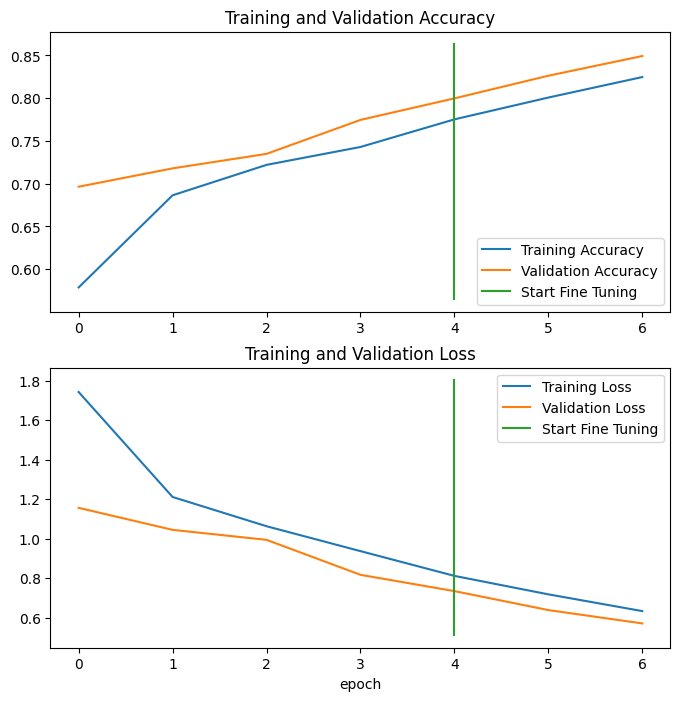

In [ ]:
compare_historys(history, history_2)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 711,061
Non-train

In [ ]:
model.load_weights(checkpoint_path)
# cannot load weights as some problem in tf 2.1x heh

ValueError: ignored

In [ ]:
preds = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 0.9949 - accuracy: 0.7297


In [ ]:
# BASE BASE MODEL SINCE CHEKPOINTING IS DOWN THE DRAIN
from tensorflow.keras import layers
base_model_0 = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model_0.trainable = False
input = layers.Input(shape=input_shape, name='input_layer')
x = base_model_0(input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)  #seperated because of mixed precision calculations done in 16 bit but saved in 32 bit in mixed precision
#  and in softmax output is a 16 bit so we have to manually make it 32 bit
model_0 = tf.keras.Model(input,output)

model_0.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 129,381
Non-train

In [ ]:
initial_epochs=3
history_01 = model_0.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=initial_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.15*(len(test_data))),
                    callbacks=[create_tensorboard_callback('training_logs',
                                                           'efficientnetv2-v2'),])

Saving TensorBoard log files to: training_logs/efficientnetv2-v2/20230630-190118
Epoch 1/3
2368/2368 [==============================] - 203s 80ms/step - loss: 1.7479 - accuracy: 0.5751 - val_loss: 1.1483 - val_accuracy: 0.6944
Epoch 2/3
2368/2368 [==============================] - 187s 78ms/step - loss: 1.2111 - accuracy: 0.6870 - val_loss: 1.0338 - val_accuracy: 0.7238
Epoch 3/3
2368/2368 [==============================] - 183s 76ms/step - loss: 1.0632 - accuracy: 0.7223 - val_loss: 0.9849 - val_accuracy: 0.7354


In [ ]:
# fine tune this one differently
base_model_0.trainable=True
for layers in base_model_0.layers[:-15]:
  layers.trainable=False

model_0.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


In [ ]:
fine_tuned_epochs=initial_epochs + 5
# more epochs + more 5 more layers
history_02 = model_0.fit(test_data, epochs=fine_tuned_epochs,
                      validation_data=test_data, validation_steps=int(0.15*(len(test_data))),
                      initial_epoch=history.epoch[-1],
                      callbacks=[create_tensorboard_callback('training_logs',
                                                             'efficientnetv2-fine_tuned_v2')])

Saving TensorBoard log files to: training_logs/efficientnetv2-fine_tuned_v2/20230630-191125
Epoch 3/8
790/790 [==============================] - 83s 89ms/step - loss: 0.9363 - accuracy: 0.7429 - val_loss: 0.8178 - val_accuracy: 0.7762
Epoch 4/8
790/790 [==============================] - 63s 80ms/step - loss: 0.8110 - accuracy: 0.7770 - val_loss: 0.7231 - val_accuracy: 0.8011
Epoch 5/8
790/790 [==============================] - 64s 81ms/step - loss: 0.7153 - accuracy: 0.8027 - val_loss: 0.6403 - val_accuracy: 0.8313
Epoch 6/8
790/790 [==============================] - 65s 82ms/step - loss: 0.6267 - accuracy: 0.8276 - val_loss: 0.5590 - val_accuracy: 0.8541
Epoch 7/8
790/790 [==============================] - 66s 84ms/step - loss: 0.5441 - accuracy: 0.8503 - val_loss: 0.4852 - val_accuracy: 0.8721
Epoch 8/8
790/790 [==============================] - 66s 84ms/step - loss: 0.4685 - accuracy: 0.8749 - val_loss: 0.4147 - val_accuracy: 0.8912


In [ ]:
model_0.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 0.3853 - accuracy: 0.9023


[0.38533851504325867, 0.9022574424743652]

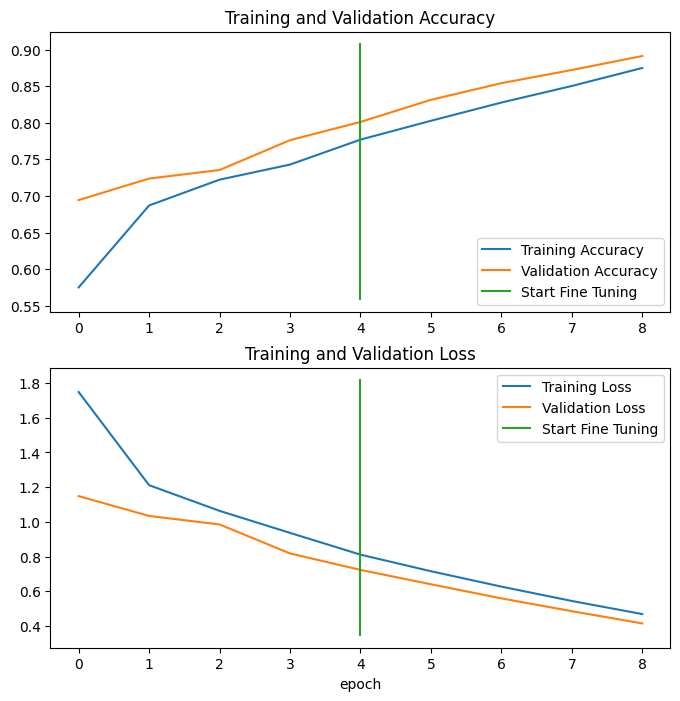

In [ ]:
compare_historys(history_01, history_02)

In [ ]:
preds = model.predict(test_data)

790/790 [==============================] - 56s 68ms/step


In [ ]:
pred_values = preds.argmax(axis=1)
pred_values

array([ 3, 91, 60, ..., 22, 65, 90])

In [ ]:
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([ 3, 91, 60, ..., 22, 65, 90])>

In [ ]:
from tqdm import tqdm
y_true = []
for image, label in tqdm(test_data):
    y_true.extend(label.numpy().tolist())
y_true

In [ ]:
import numpy as np
y_true_np = np.array(y_true)

In [ ]:
y_true_np[:32]

array([ 78, 100,  79,   4,  37,  14,  42,  69,  30,  44,  17,  44,  22,
        77,  17,   6,  83,  80,  45,  28,  23,  30,  72,  45,  94,  92,
        46,  18,  99,  75,  16,  40])

In [ ]:
one_data = test_data.take(1)
for image,label in one_data:
  print(label)

tf.Tensor(
[ 28  78 100  79   4  37  14  42  69  30  44  17  44  22  77  17   6   1
  75  61  74  54  76  34  90  15   4  15  19  49 100  93], shape=(32,), dtype=int64)


In [ ]:
iter_y_true  = np.concatenate(list(test_data.map(lambda image, label: label).as_numpy_iterator()))
iter_y_true

array([90, 33,  9, ..., 53, 11, 87])

In [ ]:
 y_true_np

array([37, 99, 40, ..., 22, 65, 90])

In [ ]:
pred_values

array([ 3, 91, 60, ..., 22, 65, 90])

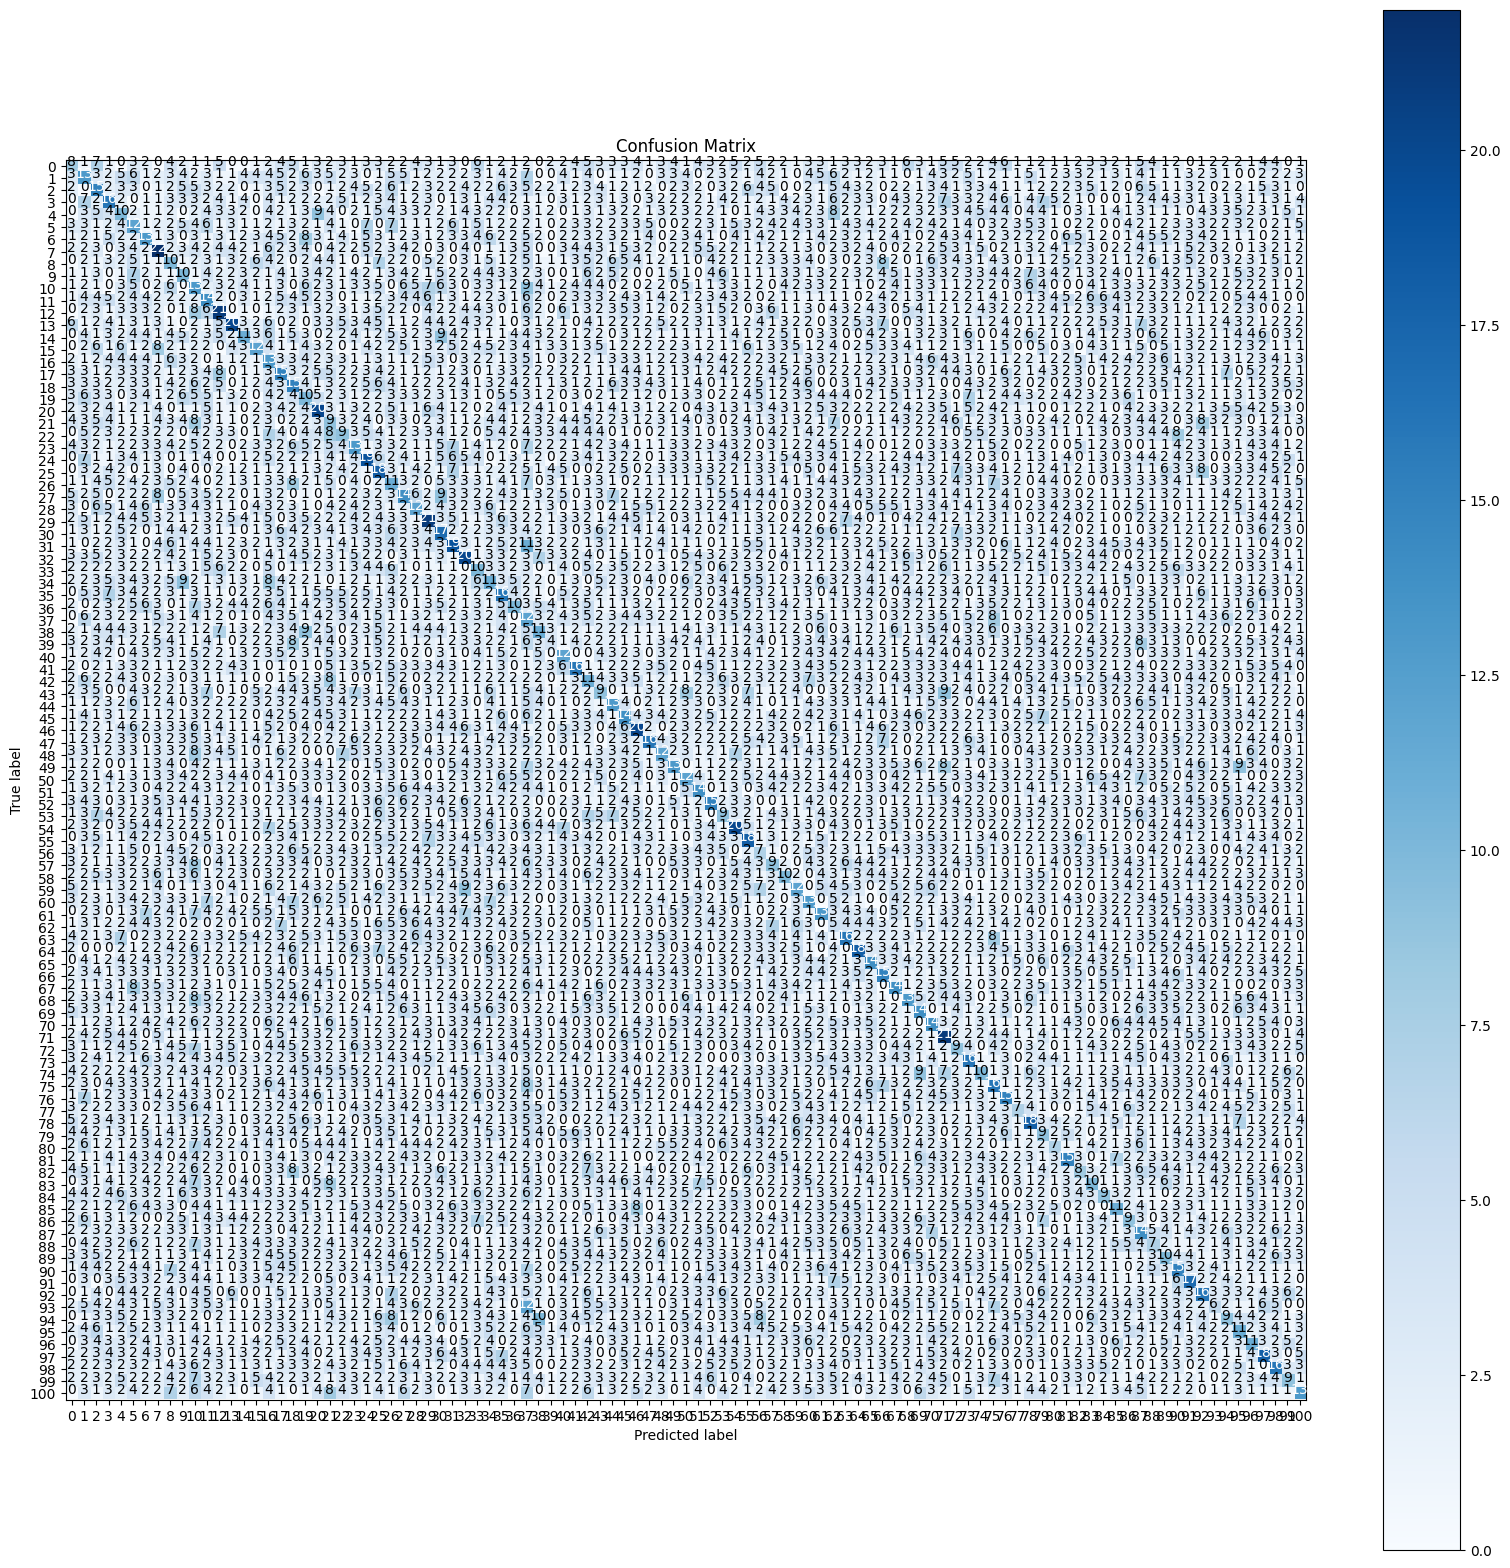

In [ ]:
make_confusion_matrix(y_true_np, pred_values,figsize=(20,20),text_size=10)